<a href="https://colab.research.google.com/github/tcmb1987/ee259-project/blob/main/EE259_radarsimpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE 259 Project

## Setup GPU, Packages, and Imports

### Enable GPU Acceleration

To enable GPU acceleration select the following menu options: Runtime -> Change runtime type -> Hardware Accelerator -> GPU

Then run snippet below. If the GPU is enabled, it will give the following output: '/device:GPU:0'

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Setup Google Drive Mount and Packages to Correctly Run Radarsimpy


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Create Ubuntu toolchain in order to run correct libstdc++6. Notice, after running the toolchain cell need to click below the prompt and hit 'Enter'.

In [ ]:
!add-apt-repository ppa:ubuntu-toolchain-r/test

Update Ubuntu for running libstdc++6 and install it. Also, install Kaleido since it's what the tutorial uses for plotting.

In [ ]:
!apt-get update
!apt-get upgrade
!apt-get install libstdc++6
!pip install kaleido

Lastly, import radarsimpy and test if successful by displaying version.

Make sure path is correct, ensure the project folder is saved under 'MyDrive'.

In [ ]:
import sys
FOLDERNAME = 'EE_259_Project' # Folder where simpy is being held in drive, e.g. 'EE_259_Project'
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

import radarsimpy
radarsimpy.__version__

'11.1.0'

Confirm Python Version is 3.10, else RadarSimPy will not function.

In [ ]:
!python --version

Python 3.10.12


###Packages to Import
Import other libraries and packages needed for the project
If radarsimpy.simulator is not importing after running above, go to: Runtime -> Restart runtime. Then, run the 'import sys' and 'import radarsimpy' cells again.

In [ ]:
import numpy as np # Numpy for arrays and numerical processing
from radarsimpy import Radar, Transmitter, Receiver # Radarsimpy Transceiver Model

from radarsimpy.simulator import simpy # Python simulator engine
from radarsimpy.simulator import simc # C++ simulator engine

# Plotting imports
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from IPython.display import Image

# Signal processing helper functions
from scipy import signal
import radarsimpy.processing as proc
from scipy.signal import find_peaks
from numpy.lib.function_base import average

##Project
All project functions are run here.

###Build Radar

Build initial radar according to parameters from Texas Instruments TIDEP-01012 cascaded MIMO radar [design guide](https://www.ti.com/lit/pdf/tiduen5) and according to the RadarSimPy TDM FMCW MIMO [tutorial](https://radarsimx.com/2019/04/07/tdm-mimo-fmcw-radar/). Initial conditions are set up for 9 TX antenna and 16 RX antennas. Facing front of board, lower-left corner is located at the origin with board facing in positive 'x' direction. Board dimensions are located in y-z plane. Using 77 GHz as frequency and 256 MHz chirp bandwidth. Also, option to initialize a board with random antenna placement.

Define the radar parameters here.

In [ ]:
# TIDEP-01012 design parameters with 77 GHz frequency
frequency = 77e9
chirp_bandwidth = 256e6
wavelength = 3e8 / frequency
theta_fov = 140
angular_res = 1.4
N = int(theta_fov//angular_res)
angle = np.linspace(-theta_fov/2, theta_fov/2, N)
tx_power = 45
pulses = 9
num_tx_channels = 9
num_rx_channels = 16
cycle_t = 32e-6
noise_level = 10
num_total_channels = num_tx_channels + num_rx_channels

# beam pattern definition (no changes from tutorial)
pattern = 20 * np.log10(np.cos(angle / 180 * np.pi) + 0.01) + 6

# define random antenna locations
tx_antenna_locations = np.zeros((num_tx_channels, 2))
rx_antenna_locations = np.zeros((num_rx_channels, 2))
tx_antenna_locations[:,0] = np.random.rand(num_tx_channels)*40*wavelength
tx_antenna_locations[:,1] = np.random.rand(num_tx_channels)*34*wavelength
rx_antenna_locations[:,0] = np.random.rand(num_rx_channels)*40*wavelength
rx_antenna_locations[:,1] = np.random.rand(num_rx_channels)*34*wavelength

random_antenna_locations = np.concatenate((tx_antenna_locations, rx_antenna_locations), axis=0)

# define initial antenna locations
tx_antenna_locations[0,:] = np.array([30.5*wavelength, 11*wavelength])
rx_antenna_locations[0,:] = np.array([7*wavelength, 30*wavelength])

for i in range(1, num_tx_channels):
    tx_antenna_locations[i,:] = np.array([tx_antenna_locations[i-1,0] - 2*wavelength, tx_antenna_locations[0,1]])
for i in range(1, num_rx_channels):
    if i == 6:
        rx_antenna_locations[i,:] = np.array([rx_antenna_locations[i-1,0] + 4*wavelength, rx_antenna_locations[0,1]])
    elif i == 9:
        rx_antenna_locations[i,:] = np.array([rx_antenna_locations[i-1,0] + 16*wavelength, rx_antenna_locations[0,1]])
    else:
        rx_antenna_locations[i,:] = np.array([rx_antenna_locations[i-1,0] + 0.5*wavelength, rx_antenna_locations[0,1]])

initial_antenna_locations = np.concatenate((tx_antenna_locations, rx_antenna_locations), axis=0)



Build radar function here.

In [ ]:
def build_radar(antenna_locations):
  tx_antenna_locations = antenna_locations[:num_tx_channels]
  rx_antenna_locations = antenna_locations[num_tx_channels:]

  # build transmitter
  tx_channels = []
  for i in range(num_tx_channels):
    tx_channels.append(dict(location=(0, tx_antenna_locations[i,0], tx_antenna_locations[i,1]),
                      azimuth_angle=angle,
                      azimuth_pattern=pattern,
                      elevation_angle=angle,
                      elevation_pattern=pattern,
                      delay=i*cycle_t))

  tx = Transmitter(f=[frequency, frequency+chirp_bandwidth],
                  t=17e-6,
                  tx_power=tx_power,
                  prp=288e-6,
                  pulses=9,
                  channels=tx_channels)

  # build receiver
  rx_channels = []
  for i in range(num_rx_channels):
    rx_channels.append(dict(location=(0, rx_antenna_locations[i,0], rx_antenna_locations[i,1]),
                      azimuth_angle=angle,
                      azimuth_pattern=pattern,
                      elevation_angle=angle,
                      elevation_pattern=pattern))

  rx = Receiver(fs=15e6,
                noise_figure=noise_level,
                rf_gain=20,
                baseband_gain=50,
                load_resistor=500,
                channels=rx_channels)

  return Radar(transmitter=tx, receiver=rx)

Build target list here.

In [ ]:
def build_targets():
  target_1 = dict(location=(160, 0, 0), speed=(0, 0, 0), rcs=25, phase=0)
  target_2 = dict(location=(80, -80, 0), speed=(0, 0, 0), rcs=20, phase=0)
  target_3 = dict(location=(30, 20, 0), speed=(0, 0, 0), rcs=8, phase=0)
  num_targets = 3

  return [target_1, target_2, target_3], num_targets

### Perform DSP
Run data through RadarSimPy for radar simulation and then perform DSP on raw signals.

In [ ]:
def get_DOA(radar, antenna_locations, baseband, num_targets):
  tx_antenna_locations = antenna_locations[:num_tx_channels]
  rx_antenna_locations = antenna_locations[num_tx_channels:]

  range_window = signal.chebwin(radar.samples_per_pulse, at=60) # is 60 correct? example says 80?
  range_profile = proc.range_fft(baseband, range_window)

  # MY CHANGES
  doppler_window = signal.chebwin(pulses, at=60) # is 60 correct?
  range_dopp_prof = proc.range_doppler_fft(baseband, range_window,doppler_window)

  # Get MIMO signal by averaging receiver returns
  P = range_dopp_prof.shape[0]
  doppler_indices = range_dopp_prof.shape[1]
  range_indices = range_dopp_prof.shape[2]
  avg_prof = np.mean(np.abs(range_dopp_prof), axis=0) # avg along number of channels- then get peaks

  # flatten, find doppler + range peak indices for targets (should be 3)
  flattened_avg_prof = avg_prof.flatten()

  # indices of peaks in flattened 1d array
  s_peaks,_ = find_peaks(flattened_avg_prof, np.percentile(flattened_avg_prof, 95))  # issue!! what do we set to to find peaks?

  # get 2d indices of peaks- should return a list of 2 (num axis) length-3 (num targets) tuples
  s_2d_peaks = np.unravel_index(s_peaks, (doppler_indices, range_indices))
  doppler_pk_idx = s_2d_peaks[0]
  range_pk_idx = s_2d_peaks[1]

  # initialize empty array to fill with rx signal about targets (like s vector from hw2q3)
  s_vec = np.empty(P,dtype='complex128')
  for pk in range(num_targets):
    di = doppler_pk_idx[pk]
    ri = range_pk_idx[pk]
    s_vec += np.array(range_dopp_prof[:,di,ri])

  my_fov = np.deg2rad(theta_fov)
  num_doa = N
  doa_grid = np.linspace(-my_fov/2, my_fov/2, num_doa)

  A = np.zeros((P, num_doa), dtype=complex)

  real_tx_pos = np.linalg.norm(tx_antenna_locations, axis=1)
  real_rx_pos = np.linalg.norm(rx_antenna_locations, axis=1)

  virtual_array_elem_pos = np.empty(P)
  idx = 0
  for tx_elem in range(num_tx_channels):
    for rx_elem in range(num_rx_channels):
      virtual_array_elem_pos[idx] = real_tx_pos[tx_elem] + real_rx_pos[rx_elem]
      idx += 1

  # Compute DOA spectrum, number of targets and respective DOA estimates
  for i in range(len(doa_grid)):
    ai = np.array(np.exp(-2*1j*np.pi/wavelength*np.sin(doa_grid[i])*np.array(virtual_array_elem_pos)))
    A[:,i] = ai

  d_multi = np.absolute(np.matmul(np.conjugate(np.transpose(A)),s_vec))

  d_peaks,_ = find_peaks(d_multi, np.percentile(d_multi, 95))
  theta_hat = np.rad2deg(doa_grid[d_peaks])

  return np.mean(d_multi[d_peaks]), 20*np.log10(d_multi), theta_hat

###Optimizer
Run a simulated annealing with momentum and cross entropy optimizer. Maximize based on average DOA amplitude.

Simulated annealing with momentum optimizer defined here.

In [ ]:
# optimization using annealing with momentum
def annealing_momentum(f, x0, n):
    alpha, f0, beta  =  0.3, f(x0), 0.8
    x_history = [x0]
    f_history = [f0]
    dims = x0.shape
    D = len(dims)
    momentum = np.zeros(x0.shape)
    for i in range(n):
        #rand dir
        dx = np.random.rand(*x0.shape)
        new_momentum = beta*momentum + dx*alpha
        fi = f(x0 + new_momentum)
        if fi > f0:
            momentum = new_momentum
            f0 = fi
            x0 = x0 + new_momentum
            x_history.append(x0)
            f_history.append(f0)
        else:
            momentum = beta*momentum

    return x0, x_history, f_history

Cross entropy method optimization defined here.

In [ ]:
def cross_entropy(f, x0, n, std_init, num_samples, num_elite):
    mu, f0 = x0, f(x0)
    sigma = std_init
    xs, fs, mus, mufs = [], [], [], []
    count = 0
    while count < n-2:
        xs.append(mu + sigma*np.random.randn(*x0.shape))
        fs.append(f(xs[-1]))
        if len(xs) == num_samples or count == n-2:
            x_array = np.asarray(xs)
            f_array = np.asarray(fs)
            ind = np.argsort(f_array)
            x_best = x_array[ind[:num_elite]]
            f_best = f_array[ind[:num_elite]]
            mu = np.mean(x_best, 0)
            mus.append(mu)
            mufs.append(f(mu))
            std = np.std(x_best, 0)
            if f_best[0] > f0:
                f0 = f_best[0]
                x0 = x_best[0]
            xs, fs = [], []
        count += 1

    return x0, mus, mufs

Define function to optimize here along with penalty function.

In [ ]:
def penalty(x):
  xc = np.ones_like(x[:,0])*(40*wavelength/2)
  xc = np.concatenate((xc, np.ones_like(x[:,1])*(34*wavelength/2)))
  x = x.flatten()
  D = wavelength*np.concatenate((np.ones(num_total_channels)*40, np.ones(num_total_channels)*34))
  xp = np.array(np.abs(x - xc)) * 2/D

  return (-1/50)*np.sum(xp**8)

def f(x):
  radar = build_radar(x)
  targets, num_targets = build_targets()
  data = simc(radar, targets)
  timestamp = data['timestamp']
  baseband = data['baseband']
  f, _, _ = get_DOA(radar, x, baseband, num_targets)

  # penalty
  p = penalty(x)
  f = f + p

  return f

###Main
Run project experiment here (call optimizer, plot, etc.).

In [ ]:
x0 = random_antenna_locations

# x, x_history, f_history = annealing_momentum(f, x0, 200)
x, x_history, f_history = cross_entropy(f, x0, 200, 1, 20, 5)

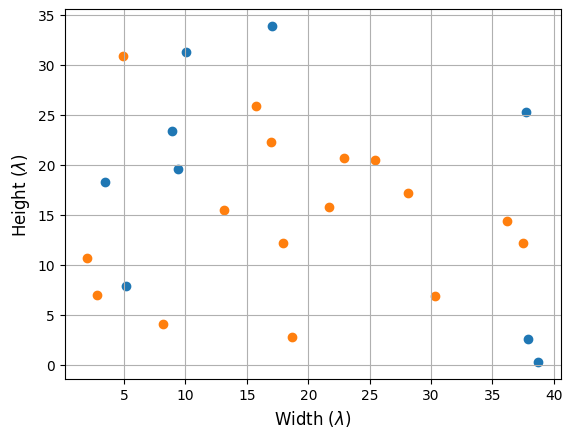

In [ ]:
x = np.array([[0.03923936, 0.1216965 ],
       [0.06638256, 0.13195469],
       [0.03667474, 0.07631205],
       [0.14777798, 0.01020302],
       [0.15091483, 0.00110744],
       [0.14697728, 0.09836831],
       [0.01354361, 0.07102248],
       [0.0201833 , 0.03074198],
       [0.03484043, 0.09091035],
       [0.01902152, 0.12024552],
       [0.06982106, 0.04745865],
       [0.14590638, 0.04730794],
       [0.07272981, 0.01080423],
       [0.06131625, 0.10060045],
       [0.1182706 , 0.02682072],
       [0.0078602 , 0.04166259],
       [0.03196735, 0.01575171],
       [0.08439428, 0.06139083],
       [0.0510699 , 0.06031396],
       [0.09923976, 0.07993431],
       [0.01092705, 0.02701453],
       [0.08914574, 0.08039772],
       [0.0662027 , 0.0866113 ],
       [0.1408482 , 0.05595424],
       [0.10956409, 0.06689413]])

x_tx = x[:9]/wavelength
x_rx = x[9:]/wavelength

# plot antenna configuration
fig1, axs1 = plt.subplots(1, 1)
axs1.scatter(x_tx[:,0], x_tx[:,1])
axs1.scatter(x_rx[:,0], x_rx[:,1])
axs1.set_xlabel('Width ($\lambda$)', fontsize=12)
axs1.set_ylabel('Height ($\lambda$)', fontsize=12)
axs1.grid(visible=True)
plt.show()

In [ ]:
f_history

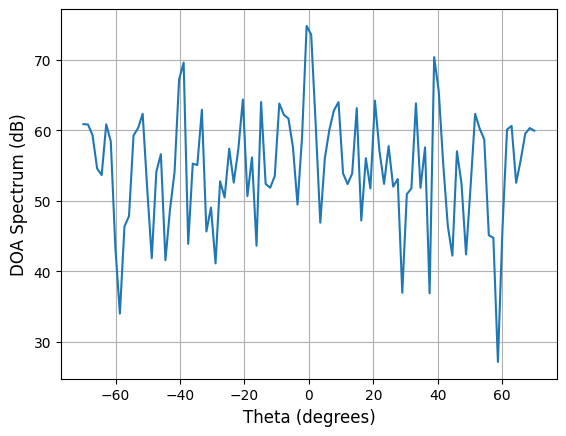

In [ ]:
# x = initial_antenna_locations
radar = build_radar(x)
targets, num_targets = build_targets()
data = simc(radar, targets)
timestamp = data['timestamp']
baseband = data['baseband']
f, spectrum, theta_hat = get_DOA(radar, x, baseband, num_targets)

# plot the DOA Spectrum
fig1, axs1 = plt.subplots(1, 1)
axs1.plot(angle, spectrum)
axs1.set_xlabel('Theta (degrees)', fontsize=12)
axs1.set_ylabel('DOA Spectrum (dB)', fontsize=12)
axs1.grid(visible=True)
plt.show()